In [2]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
from google.colab import files


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/Compute Vision/U2-Net/ECSSD_Dataset/Images"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/Compute Vision/U2-Net/ECSSD_Dataset/Masks"

In [5]:


# Custom Dataset Class with Augmentation
class ECSSDDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.train = train
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

        # Verify matching pairs
        assert len(self.image_files) == len(self.mask_files)
        for img, mask in zip(self.image_files, self.mask_files):
            assert os.path.splitext(img)[0] == os.path.splitext(mask)[0]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale

        if self.transform:
            seed = torch.random.seed()

            # Apply same transform to both image and mask
            torch.random.manual_seed(seed)
            image = self.transform(image)

            torch.random.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

In [6]:
# Define transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Simpler transform for validation
val_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = ECSSDDataset(image_dir, mask_dir, transform=train_transform, train=True)
test_dataset = ECSSDDataset(image_dir, mask_dir, transform=val_transform, train=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [8]:
# Define hybrid loss function
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(HybridLoss, self).__init__()
        self.alpha = alpha  # Weight for BCE
        self.beta = beta    # Weight for Dice

    def forward(self, pred, target):
        # Binary Cross Entropy
        bce = F.binary_cross_entropy(pred, target)

        # Dice Loss
        smooth = 1e-8
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

        # IoU (for monitoring)
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + smooth) / (union + smooth)

        return self.alpha * bce + self.beta * dice, iou.item()

In [9]:
# Initialize model, loss, optimizer and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = U2NETP(in_ch=3, out_ch=1).to(device)

cuda


In [10]:
# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

criterion = HybridLoss(alpha=0.7, beta=0.3)  # More weight to BCE
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [11]:
# Enhanced training function
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100,
          model_path='/content/drive/MyDrive/Colab Notebooks/Compute Vision/U2-Net/Model/best_u2net_small.pth'):

    best_iou = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

    # Check for existing model
    if os.path.exists(model_path):
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            best_iou = checkpoint['best_iou']
            start_epoch = checkpoint['epoch'] + 1
            print(f"Loaded checkpoint from epoch {start_epoch} with best IoU: {best_iou:.4f}")
        except:
            start_epoch = 0
            print("Failed to load checkpoint, starting from scratch")
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0

        # Training phase
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # Forward pass
            d0, d1, d2, d3, d4, d5, d6 = model(images)

            # Calculate hybrid loss (main output d0)
            loss, _ = criterion(d0, masks)

            # Backward pass with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                d0, _, _, _, _, _, _ = model(images)
                loss, iou = criterion(d0, masks)
                val_loss += loss.item()
                val_iou += iou

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(test_loader)
        val_iou /= len(test_loader)

        # Update learning rate
        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        # Print metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_iou': best_iou,
                'history': history,
            }, model_path)
            print(f'Saved new best model with IoU: {best_iou:.4f}')

    return model, history


In [12]:
# Start training
trained_model, history = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50
)

Loaded checkpoint from epoch 48 with best IoU: 0.4904


Epoch 49/50: 100%|██████████| 125/125 [03:41<00:00,  1.77s/it]



Epoch 49/50:
Train Loss: 0.3456 | Val Loss: 1.4050 | Val IoU: 0.4717
Current LR: 3.13e-06


Epoch 50/50: 100%|██████████| 125/125 [01:09<00:00,  1.79it/s]



Epoch 50/50:
Train Loss: 0.3432 | Val Loss: 1.3860 | Val IoU: 0.4694
Current LR: 3.13e-06


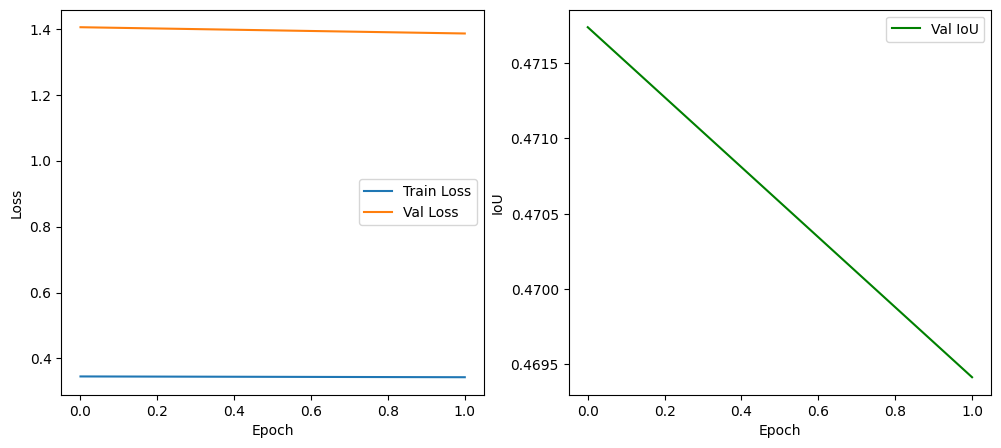

In [13]:
# Plot training curves (optional)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

Model loaded successfully


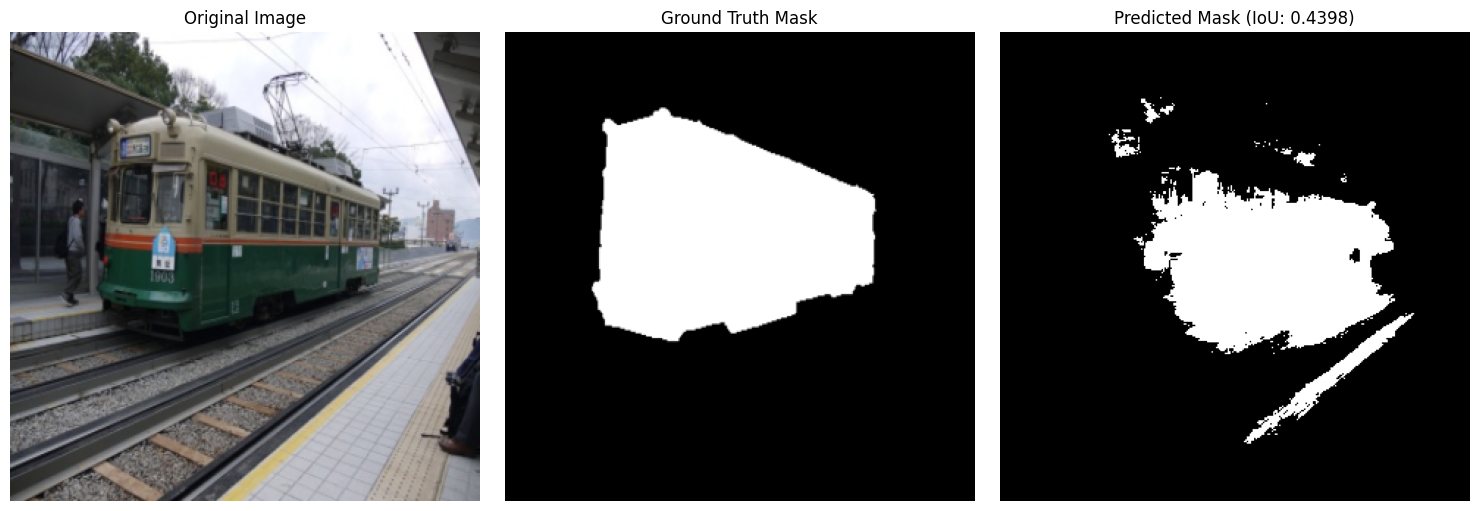

In [14]:


def visualize_results(model_path, dataset, device):
    # Load the trained model
    model = U2NETP(in_ch=3, out_ch=1).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("Model loaded successfully")

    # Select a random sample from the dataset
    idx = random.randint(0, len(dataset)-1)
    image, true_mask = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        pred_mask, _, _, _, _, _, _ = model(image)

    # Convert to numpy arrays
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    true_mask_np = true_mask.squeeze().cpu().numpy()
    pred_mask_np = pred_mask.squeeze().cpu().numpy()

    # Threshold the prediction
    pred_mask_np = (pred_mask_np > 0.5).astype(np.float32)

    # Calculate metrics
    intersection = np.logical_and(true_mask_np, pred_mask_np)
    union = np.logical_or(true_mask_np, pred_mask_np)
    iou = np.sum(intersection) / np.sum(union)

    # Create figure
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_np, cmap='gray')
    plt.title(f'Predicted Mask (IoU: {iou:.4f})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to your saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/Compute Vision/U2-Net/Model/best_u2net_small.pth'

# Visualize results on test dataset
visualize_results(model_path, test_dataset, device)

Saving butterfly.png to butterfly.png
Uploaded file: butterfly.png
Model loaded successfully


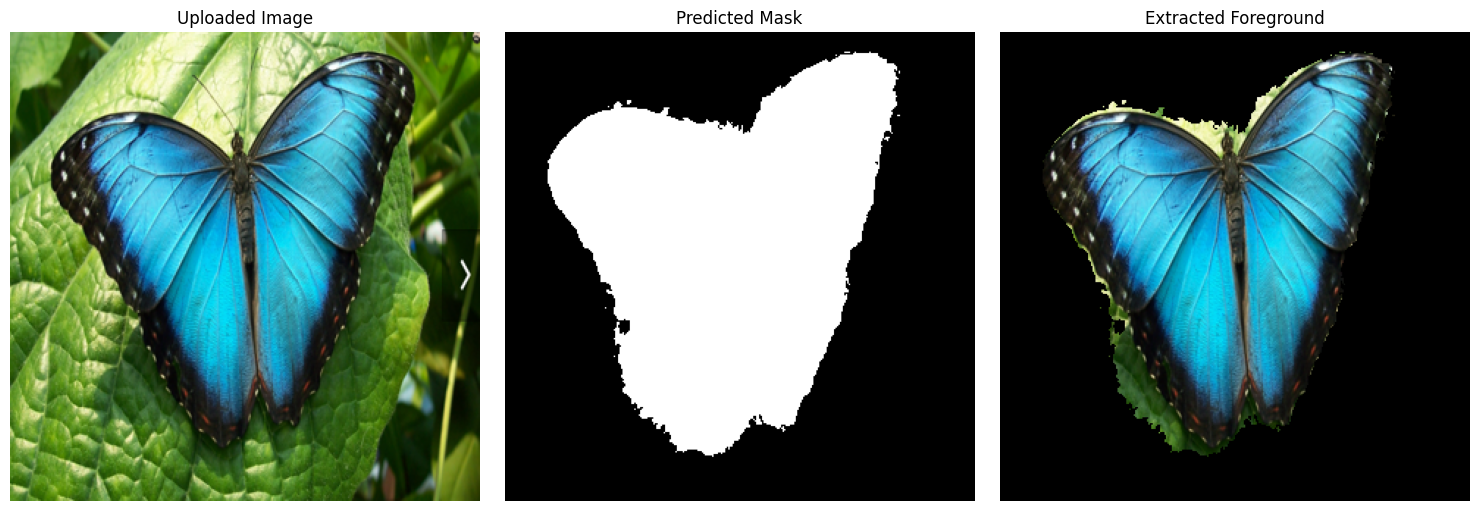

Foreground saved as salient_feature.png


In [16]:


def load_model(model_path, device):
    model = U2NETP(in_ch=3, out_ch=1).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("Model loaded successfully")
    return model

def visualize_and_extract(model_path, device):
    # Upload file
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]
    print(f"Uploaded file: {image_path}")

    # Load the trained model
    model = load_model(model_path, device)

    # Define preprocessing
    transform = transforms.Compose([
        transforms.Resize((320, 320)),   # match training size
        transforms.ToTensor(),
    ])

    # Load and preprocess uploaded image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        pred_mask, _, _, _, _, _, _ = model(input_tensor)

    # Convert to numpy
    image_resized = image.resize((320, 320))
    image_np = np.array(image_resized)
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    pred_mask_np = (pred_mask_np > 0.5).astype(np.uint8)  # binary mask (0,1)

    # Extract salient feature
    salient_np = image_np * pred_mask_np[:, :, np.newaxis]  # apply mask

    # Plot results
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Uploaded Image")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask_np, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Extracted salient feature
    plt.subplot(1, 3, 3)
    plt.imshow(salient_np)
    plt.title("Extracted Foreground")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Optionally save extracted image
    salient_img = Image.fromarray(salient_np.astype(np.uint8))
    salient_img.save("salient_feature.png")
    print("Foreground saved as salient_feature.png")


# Path to your saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/Compute Vision/U2-Net/Model/best_u2net_small.pth'
visualize_and_extract(model_path, device)
